## Accessing Gecco data via public SRA subject and sample data
This notebook explores using GA4GH DRS to access data stored in the cloud for a controlled access dbGaP project - [phs001554](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001554.v1.p1) "Detection of Colorectal Cancer Susceptibility Loci Using Genome-Wide Sequencing".

A query using the  data on public subject and sample attributes held in SRA BigQuery. Gen3 DRS ids are accessed in BigQuery uploaded from a Gen3 manifest file. 

>
>The sequence files used in this notebook are  under controlled access. You will not be able to access those files unless you have been granted access through dbGaP to the phs001554 study. If you have that access you will also have access to the non-scrambled subject and sample data. If that is the case, we would be pleased to hear of your interest, and the possibility of collaborating to ensure the GA4GH tools described here enable your studies. Please see [form to register interest](https://docs.google.com/forms/d/e/1FAIpQLSfmmc3VKd6ANdzaVMyelT3c9gIWuoS4ZwT0vsqD-o2ZRxJf7A/viewform)

In [7]:
from fasp.search import BigQuerySearchClient
from fasp.loc import crdcDRSClient
from fasp.workflow import sbcgcWESClient
from fasp.runner import FASPRunner

faspRunner = FASPRunner(program='GECCO_Gen3_on_SB')
runNote = 'GECCO files retrieved from Gen3 DRS and computed on SB'

searchClient = BigQuerySearchClient()
query = '''select sra.acc,  drs_id
from `dnastack-main.cshcodeathon.gecco_gen3_drs_index` i
join `nih-sra-datastore.sra.metadata` sra on sra.acc = i.acc
CROSS JOIN UNNEST(sra.attributes) AS atts
where atts.k = 'subject_is_affected_sam' and atts.v = 'Yes'
and sra.consent = 'DS-CC-NPU-GSO'
and file_type = 'cram' limit 3'''
df = searchClient.runQuery(query, returnType='dataframe')
df

,acc,drs_id
0,SRR7271807,dg.4DFC/546f87bb-a6d1-4646-b7f0-c364b83bfc6c
1,SRR7272153,dg.4DFC/7c257b0c-cf3a-4fed-9399-215535feadbc
2,SRR7272242,dg.4DFC/72234296-5663-4f5b-9948-ebcec69fd798


In [8]:
drsClient = crdcDRSClient('/Users/forei/.keys/crdc_credentials.json', 's3')

settings = faspRunner.settings
wesClient = sbcgcWESClient(settings['SevenBridgesProject'])

faspRunner.configure(searchClient, drsClient, wesClient)

run_ids = faspRunner.runQuery(query, runNote)
import pandas as pd
runs_df = pd.DataFrame(run_ids)
runs_df

Running query
select sra.acc,  drs_id
from `dnastack-main.cshcodeathon.gecco_gen3_drs_index` i
join `nih-sra-datastore.sra.metadata` sra on sra.acc = i.acc
CROSS JOIN UNNEST(sra.attributes) AS atts
where atts.k = 'subject_is_affected_sam' and atts.v = 'Yes'
and sra.consent = 'DS-CC-NPU-GSO'
and file_type = 'cram' limit 3
subject=SRR7271807, drsID=dg.4DFC/546f87bb-a6d1-4646-b7f0-c364b83bfc6c
workflow submitted, run:54ce39bf-cf99-4f10-af07-e3cdb45b4c85
____________________________________________________________
subject=SRR7272153, drsID=dg.4DFC/7c257b0c-cf3a-4fed-9399-215535feadbc
workflow submitted, run:137c22e7-d88a-4a2b-9039-3dd1f34f4249
____________________________________________________________
subject=SRR7272242, drsID=dg.4DFC/72234296-5663-4f5b-9948-ebcec69fd798
workflow submitted, run:d86b18e9-2603-47bb-96e3-95e194dd6730
____________________________________________________________


,subject,run_id
0,SRR7271807,54ce39bf-cf99-4f10-af07-e3cdb45b4c85
1,SRR7272153,137c22e7-d88a-4a2b-9039-3dd1f34f4249
2,SRR7272242,d86b18e9-2603-47bb-96e3-95e194dd6730


In [9]:
merged_df = pd.merge(
    df,
    runs_df,
    how="inner",
    left_on='acc',
    right_on='subject'
)
merged_df.drop('subject', axis=1, inplace=True)
merged_df.drop('drs_id', axis=1, inplace=True)
merged_df.to_csv('~/mywork.csv')
merged_df

,acc,run_id
0,SRR7271807,54ce39bf-cf99-4f10-af07-e3cdb45b4c85
1,SRR7272153,137c22e7-d88a-4a2b-9039-3dd1f34f4249
2,SRR7272242,d86b18e9-2603-47bb-96e3-95e194dd6730


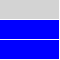

In [10]:
faspRunner.getFASPicon()

Update the dataframe with the status of the runs

In [18]:
for index, row in merged_df.iterrows():
    status = wesClient.getTaskStatus(row['run_id'])
    merged_df.at[index, "status"] = status
merged_df

,acc,run_id,status
0,SRR7271807,54ce39bf-cf99-4f10-af07-e3cdb45b4c85,COMPLETE
1,SRR7272153,137c22e7-d88a-4a2b-9039-3dd1f34f4249,COMPLETE
2,SRR7272242,d86b18e9-2603-47bb-96e3-95e194dd6730,COMPLETE


Once the runs have completed the results can be retrieved.

In [19]:
statsRequired = ['raw total sequences',
                 'sequences',
                 'reads mapped',
                 'insert size average',
                 'insert size standard deviation']
statsList = []
for index, row in merged_df.iterrows():
    stats =  wesClient.getSAMToolsResults(row['run_id'], statsRequired)
    stats['acc'] = row['acc']
    statsList.append(stats)

stats_df =  pd.DataFrame(statsList)

Searching the GA4GH registry for org.ga4gh:drs services


In [20]:
stats_df

,raw total sequences,sequences,reads mapped,insert size average,insert size standard deviation,acc
0,918535181,918535181,907736629,324.5,83.7,SRR7271807
1,876816395,876816395,868565288,333.1,82.5,SRR7272153
2,796938984,796938984,788007106,338.9,86.2,SRR7272242


In [21]:
final_df = pd.merge(
    merged_df,
    stats_df,
    how="inner",
    left_on='acc',
    right_on='acc'
)
final_df.drop('status', axis=1, inplace=True)
final_df.drop('run_id', axis=1, inplace=True)

final_df

,acc,raw total sequences,sequences,reads mapped,insert size average,insert size standard deviation
0,SRR7271807,918535181,918535181,907736629,324.5,83.7
1,SRR7272153,876816395,876816395,868565288,333.1,82.5
2,SRR7272242,796938984,796938984,788007106,338.9,86.2
